# Bank loan model : The big picture


This case is about a bank (**Thera Bank**) which has a growing customer base.


Majority of these customers are **liability customers** (depositors) with varying size of deposits. The number of customers who are also borrowers (asset customers) is quite small, and **the bank is interested in expanding this base rapidly to bring in more loan business and in the process, earn more through the interest on loans**. 


In particular, the management wants to **explore ways of converting its liability customers to personal loan customers (while retaining them as depositors)**. 


A campaign that the bank ran last year for liability customers showed **a healthy conversion rate of over 9% success**. 


This has encouraged the retail marketing department to devise campaigns to better target marketing to increase the success ratio with a minimal budget.




## Framing the problem


### What is the business objective ?


The department wants to build a model that will **help them identify the potential customers who have a higher probability of purchasing the loan**. 

**This will increase the success ratio while at the same time reduce the cost of the campaign**.



### What is the type of learning ?



With the gathered information, we are ready to design our system.<br>

- This is a **supervised learning task** because the model can train on labeled examples (customers who actually purchased a loan). <br>


- It’s a **classification task** since the goal is to predict the likelihood of customers to purchase a loan or not. <br>



## Selecting a performance measure


The next step is to choose a performance measure. <br>

For our case, the main metric to use is the **recall** :   $$recall  = \frac{TP}{TP + FN}$$<br>
with **TP** : True Positives and **FN** : False Negatives



In machine learning, recall is a performance metric that measures the ability of a classification model to correctly identify all relevant instances of the positive class. <br>

It is particularly important in situations **where missing positive cases (false negatives) is more critical than incorrectly classifying negatives as positives**. <br>

In other words, we are interested in **detecting most of the customers that would purchase a loan** and **we accept a higher number of False Positive** detection.




Additionally, we will calculate : <br>
- the precision :  $$precision  = \frac{TP}{TP + FP}$$ <br>

- the F1 score :    $$F_1  = \frac{2}{\frac{1}{precision}+ \frac{1}{recall}} = 2 \times \frac{precision \times recall}{precision + recall} = \frac{TP}{TP +  \frac{FN + FP}{2}} $$ <br><br>


with **TP** : True Positives and **FN** : False Negatives


In machine learning, **precision** is a metric used to evaluate the performance of a classification model, especially in cases where the classes are imbalanced or when the cost of false positives is high.<br>
Precision focuses on the proportion of correctly identified positive instances out of all instances that were predicted as positive.

The **F1 score** is a performance metric used in machine learning to evaluate the accuracy of a classification model, especially when dealing with imbalanced datasets. <br>
It is the harmonic mean of precision and recall, providing a single score that balances the trade-off between them.


# Getting the data


## Import libraries


Here will be imported all the necessary libraries that we'll use for this task !

In [1]:
import warnings
warnings.filterwarnings(action = 'ignore')

# General libraries
import pandas as pd
import numpy as np
import math
from scipy.stats import iqr


# Visualization
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
import plotly.express as px

# Split train set and test set
from sklearn.model_selection import train_test_split

# Geolocation libraries
import pgeocode 
from geopy.geocoders import Nominatim

# Preprocessing the data
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler, MinMaxScaler

# Pipelines
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import make_union
from sklearn.compose import make_column_transformer


# Models
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier


# Scores
from sklearn.metrics import recall_score, precision_score, f1_score

from sklearn.metrics import classification_report



## Import the data


We import the data and store it locally.

In [2]:
# Retrieve the data stored locally
path = "../data/raw_data"
banking_data = pd.read_excel(path + "/Bank_Personal_Loan_Modelling.xlsx", sheet_name="Data")

banking_data.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [3]:
banking_data.shape

(5000, 14)

## Describe the features


We have the following features : <br>
**ID**: Customer ID<br>
**Age**: Customer's age in completed years<br>
**Experience**: #years of professional experience<br>
**Income**: Annual income of the customer (**in thousands of dollars**) <br>
**ZIP_Code**: Home Address ZIP code.<br>
**Family**: Family size of the customer <br>
**CCAvg**: Avg. spending on credit cards per month (**in thousands of dollars**)<br>
**Education**: Education Level. 1: Undergrad; 2: Graduate; 3: Advanced/Professional<br>
**Mortgage**: Value of house mortgage if any (**in thousands of dollars**).<br>
**Personal Loan**: Did this customer accept the personal loan offered in the last campaign?<br>
**Securities Account**: Does the customer have a securities account with the bank?<br>
**CD Account**: Does the customer have a certificate of deposit (CD) account with the bank?<br>
**Online**: Does the customer use internet banking facilities?<br>
**CreditCard**: Does the customer use a credit card issued by UniversalBank?<br>



## Rewrite feature names


Updating the feature names for easier use.


In [4]:
# Updating the feature names for easier use.
banking_data = banking_data.rename(columns={
                                            "ZIP Code":"ZIP_Code", 
                                            "Personal Loan":"Personal_Loan",
                                            "Securities Account":"Securities_Account",
                                            "CD Account": "CD_Account"
                                            })

banking_data.head(2)

,ID,Age,Experience,Income,ZIP_Code,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0


## Dropping features


We won't need the ID column. Let's drop it !


In [5]:
# We won't need the ID column. Let's drop it !
banking_data = banking_data.drop(columns=['ID'])
banking_data.head(2)

,Age,Experience,Income,ZIP_Code,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard
0,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,45,19,34,90089,3,1.5,1,0,0,1,0,0,0


## Cleaning the data

### Processing duplicates

We check the number of duplicated rows.

In [6]:
# Check number of rows before removing duplicates
print(f"Number of rows : {len(banking_data)}")

# Compute the number of duplicated rows
print(f"Number of duplicated rows : {banking_data.duplicated().sum()}")

# Remove duplicates
banking_data = banking_data.drop_duplicates() 

# Check number of rows before removing duplicates
print(f"Number of rows (AFTER dropping duplicates) : {len(banking_data)}")

Number of rows : 5000
Number of duplicated rows : 0
Number of rows (AFTER dropping duplicates) : 5000


### Processing missing data




We check the percentage of missing values in the data at hand.

In [7]:
def get_missing_data(data):       
    # Counting the percentage of NaN for each column
    missing_data = data.isnull().sum().sort_values(ascending=False)/len(data)*100 #NaN percentage for each column

    # missing_data
    missing_data = missing_data[missing_data > 0]

    #Missing data column names
    missing_cols = missing_data.index.values.tolist()

    #Show missing data in percent
    return missing_data

missing_data = get_missing_data(banking_data)
missing_data


Series([], dtype: float64)

We don't have missing values.


# Exploring the data


## Quick exploration

In [8]:
# summary of the DataFrame
banking_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 5000 non-null   int64  
 1   Experience          5000 non-null   int64  
 2   Income              5000 non-null   int64  
 3   ZIP_Code            5000 non-null   int64  
 4   Family              5000 non-null   int64  
 5   CCAvg               5000 non-null   float64
 6   Education           5000 non-null   int64  
 7   Mortgage            5000 non-null   int64  
 8   Personal_Loan       5000 non-null   int64  
 9   Securities_Account  5000 non-null   int64  
 10  CD_Account          5000 non-null   int64  
 11  Online              5000 non-null   int64  
 12  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(12)
memory usage: 546.9 KB


In [9]:
# Descriptive statistics
banking_data.describe()

,Age,Experience,Income,ZIP_Code,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000
mean,45.338400,20.104600,73.774200,93152.503000,2.396400,1.937913,1.881000,56.498800,0.096000,0.104400,0.06040,0.596800,0.294000
std,11.463166,11.467954,46.033729,2121.852197,1.147663,1.747666,0.839869,101.713802,0.294621,0.305809,0.23825,0.490589,0.455637
min,23.000000,-3.000000,8.000000,9307.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,35.000000,10.000000,39.000000,91911.000000,1.000000,0.700000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,45.000000,20.000000,64.000000,93437.000000,2.000000,1.500000,2.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000
75%,55.000000,30.000000,98.000000,94608.000000,3.000000,2.500000,3.000000,101.000000,0.000000,0.000000,0.00000,1.000000,1.000000
max,67.000000,43.000000,224.000000,96651.000000,4.000000,10.000000,3.000000,635.000000,1.000000,1.000000,1.00000,1.000000,1.000000


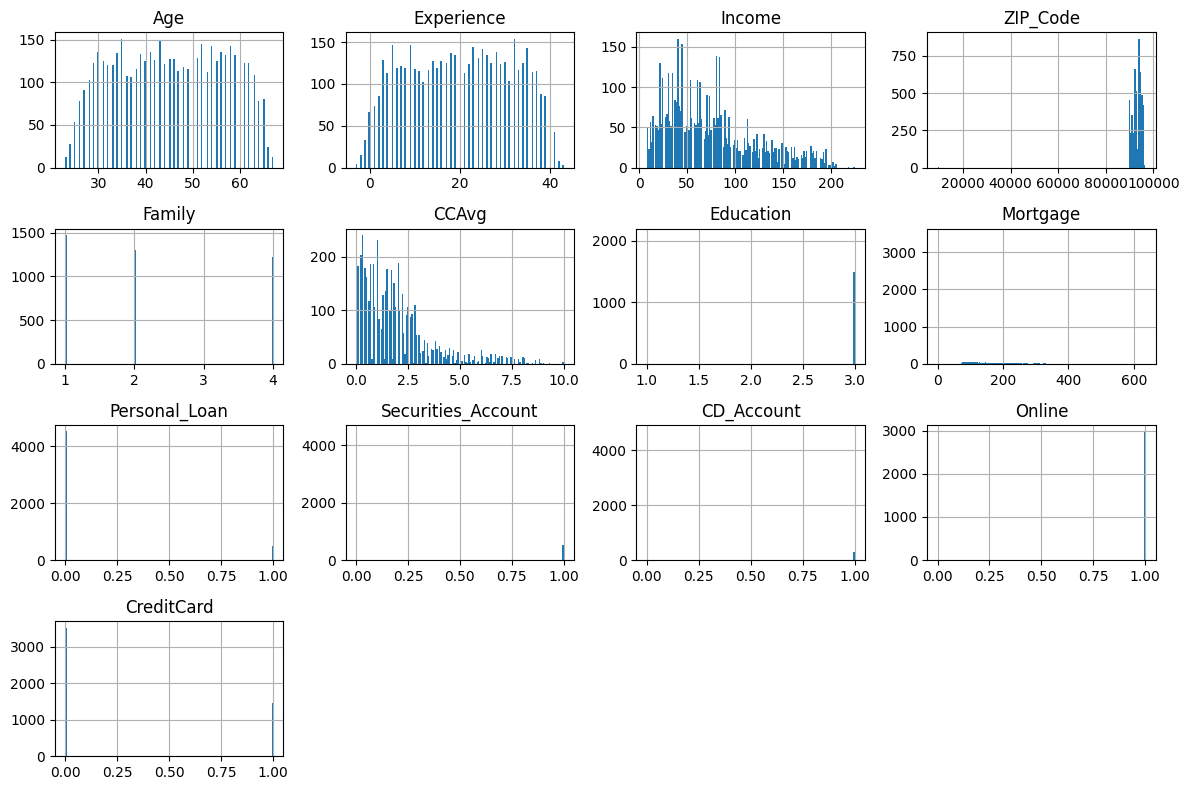

In [10]:
# Histogram of the DataFrame’s columns
banking_data.hist(bins=150, figsize=(12, 8))
plt.tight_layout()
plt.show()

## Test set and train set

### Check target balance


Our target is **Personal_Loan**. <br> 
Let's check the balance of the target.


In [11]:
# Our target is Personal_Loan. Let's check the balance of the target.
banking_data.Personal_Loan.value_counts()/len(banking_data)*100


0    90.4
1     9.6
Name: Personal_Loan, dtype: float64

Less than 10% of customers accepted the personal loan offered in the last campaign. <br>
We'll need to stratify the test set and the train set to have the same proportions of labels. 


### Train set and test set: Stratification



We split the data in : <br>
- a train on which we will train our final model
- a test set we will use to evaluate the model (in the end)

In [12]:
# Create train set and test set (stratified based on median incom categories)
strat_train_set, strat_test_set = train_test_split(
    banking_data, test_size=0.2, stratify=banking_data["Personal_Loan"], random_state=42)

In [13]:
# Check of stratified train set
strat_train_set.Personal_Loan.value_counts()/len(strat_train_set)*100

0    90.4
1     9.6
Name: Personal_Loan, dtype: float64

In [14]:
# Check of stratified test set
strat_test_set.Personal_Loan.value_counts()/len(strat_test_set)*100

0    90.4
1     9.6
Name: Personal_Loan, dtype: float64

# Prepare the data for Machine Learning Algorithms


We separate the features from the target.

In [15]:
# Separate featues from target
X = strat_train_set.drop(["Personal_Loan"], axis=1)
y = strat_train_set["Personal_Loan"].copy()

## Checking for outliers in numerical features


Let's check the outliers of the numerical columns.


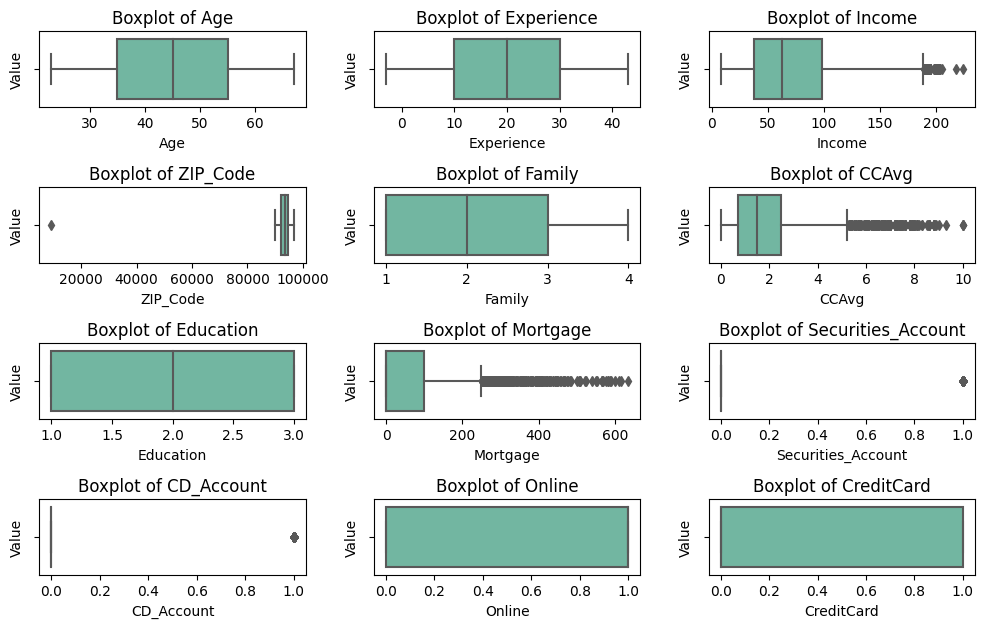

In [16]:
# Plot boxplots of each numerical column
plt.figure(figsize=(10, 20))

# for column in housing_num_tr.columns: 
for i, column in enumerate(X.columns, 1):
    plt.subplot(13, 3, i)
    sns.boxplot(x=X[column], palette='Set2')
    plt.title(f'Boxplot of {column}')
    plt.xlabel(column)
    plt.ylabel('Value')

plt.tight_layout()
plt.show()


It would be useful to extract the features containing outliers **automatically**. It will be used for pipeline implementation.


Let's extract the features with outliers **numerically** !


In [17]:
# Identify the columns with outliers
numerical_columns_w_outliers = []
numerical_columns_no_outliers = []

for col in X.columns: 
    # Calculate IQR
    iqr_value = iqr(X[col])

    #Calculate 1st quartile
    q1 = np.percentile(X[col],25)

    #Calculate 3rd quartile
    q3 = np.percentile(X[col],75)

    #Calculate lower limit below which data point is considered an outlier
    outlier_lim_low = q1 - 1.5 * iqr_value

    #Calculate higher limit above which data point is considered an outlier
    outlier_lim_high = q3 + 1.5 * iqr_value
    
    #Calculate number of 'low' outliers
    outlier_condition_low = X[col] < outlier_lim_low
    number_outliers_low = len(X[outlier_condition_low][col])
    
    #Calculate number of 'high' outliers
    outlier_condition_high = X[col] > outlier_lim_high
    number_outliers_high = len(X[outlier_condition_high][col])
    
    #Calculate total number of outliers
    number_outliers_total = number_outliers_low + number_outliers_high
      
    #If any outliers in column, column is added to a list of columns with outliers
    if number_outliers_total > 0:
        numerical_columns_w_outliers.append(col)
    elif number_outliers_total == 0:
        numerical_columns_no_outliers.append(col)      

Let's check if we could extract the outliers numerically !


In [18]:
print(f"The features having outliers are : {numerical_columns_w_outliers}")
print(f"The features WITHOUT outliers are : {numerical_columns_no_outliers}")

The features having outliers are : ['Income', 'ZIP_Code', 'CCAvg', 'Mortgage', 'Securities_Account', 'CD_Account']
The features WITHOUT outliers are : ['Age', 'Experience', 'Family', 'Education', 'Online', 'CreditCard']


## Feature scaling and transformation


**WHY SCALING ??**

❗️ Features with large magnitudes can incorrectly outweigh features of small magnitudes <br>
⚡️ Scaling to smaller magnitudes improves computational efficiency <br>
🕵🏻‍♂️ Increases interpretability about the impact of each feature in a Machine Learning model <br>

### Columns with outliers


<span style="font-family:Comic Sans MS; color:red">We consider using Robust scaling for columns WITH outliers !  </span>

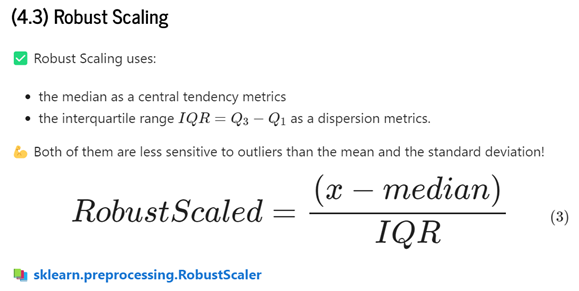


In [19]:
# Reminder of features with outliers
display(numerical_columns_w_outliers)


['Income', 'ZIP_Code', 'CCAvg', 'Mortgage', 'Securities_Account', 'CD_Account']

Let's have a look of the statistics of numerical columns with outliers (**BEFORE SCALING**).

In [20]:
# Describe columns with outliers
X[numerical_columns_w_outliers].describe()

,Income,ZIP_Code,CCAvg,Mortgage,Securities_Account,CD_Account
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,73.479750,93156.583750,1.921779,55.968250,0.104000,0.061500
std,46.321345,2197.762636,1.738982,101.054887,0.305299,0.240275
min,8.000000,9307.000000,0.000000,0.000000,0.000000,0.000000
25%,38.000000,91941.750000,0.700000,0.000000,0.000000,0.000000
50%,63.000000,93407.000000,1.500000,0.000000,0.000000,0.000000
75%,98.000000,94608.000000,2.500000,100.000000,0.000000,0.000000
max,224.000000,96651.000000,10.000000,635.000000,1.000000,1.000000


In [21]:
# Instantiate Robustscaler
robust_scaler = RobustScaler()

# Fit and transform
X[numerical_columns_w_outliers] = robust_scaler.fit_transform(X[numerical_columns_w_outliers])
X[numerical_columns_w_outliers].head(3)



,Income,ZIP_Code,CCAvg,Mortgage,Securities_Account,CD_Account
408,0.433333,-0.623347,0.722222,0.00,0.0,0.0
3737,-0.550000,-0.744116,-0.555556,0.00,0.0,0.0
3889,-0.733333,-0.147398,-0.777778,1.21,0.0,0.0


Now, let's check the statistics of the numerical columns with outliers (**AFTER SCALING**).

In [22]:
# Describe columns with outliers
X[numerical_columns_w_outliers].describe()


,Income,ZIP_Code,CCAvg,Mortgage,Securities_Account,CD_Account
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.174663,-0.093921,0.234322,0.559682,0.104000,0.061500
std,0.772022,0.824290,0.966101,1.010549,0.305299,0.240275
min,-0.916667,-31.542429,-0.833333,0.000000,0.000000,0.000000
25%,-0.416667,-0.549555,-0.444444,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.583333,0.450445,0.555556,1.000000,0.000000,0.000000
max,2.683333,1.216690,4.722222,6.350000,1.000000,1.000000


### Columns without outliers


<span style="font-family:Comic Sans MS; color:red">We consider using MinMax scaling for columns WITHOUT outliers !  </span>

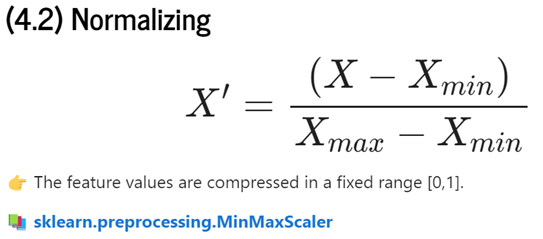
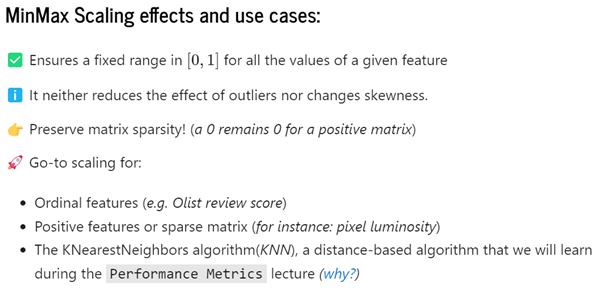


Let's have a look of the statistics of numerical columns without outliers (**BEFORE SCALING**).

In [23]:
# Describe columns with NO outliers
X[numerical_columns_no_outliers].describe()


,Age,Experience,Family,Education,Online,CreditCard
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.00000
mean,45.429500,20.196250,2.381750,1.881500,0.599000,0.29050
std,11.489235,11.500143,1.149716,0.842102,0.490162,0.45405
min,23.000000,-3.000000,1.000000,1.000000,0.000000,0.00000
25%,35.000000,10.000000,1.000000,1.000000,0.000000,0.00000
50%,45.000000,20.000000,2.000000,2.000000,1.000000,0.00000
75%,55.000000,30.000000,3.000000,3.000000,1.000000,1.00000
max,67.000000,43.000000,4.000000,3.000000,1.000000,1.00000


In [24]:
#Instanciate, fit, transform with minmax scaler
minmax_scaler = MinMaxScaler()
X[numerical_columns_no_outliers] = minmax_scaler.fit_transform(X[numerical_columns_no_outliers])



Now, let's check the statistics of the numerical columns without outliers (**AFTER SCALING**).

In [25]:
# Describe columns with NO outliers
X[numerical_columns_no_outliers].describe()

,Age,Experience,Family,Education,Online,CreditCard
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.00000
mean,0.509761,0.504266,0.460583,0.440750,0.599000,0.29050
std,0.261119,0.250003,0.383239,0.421051,0.490162,0.45405
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,0.272727,0.282609,0.000000,0.000000,0.000000,0.00000
50%,0.500000,0.500000,0.333333,0.500000,1.000000,0.00000
75%,0.727273,0.717391,0.666667,1.000000,1.000000,1.00000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


# SMOTE


In [26]:
# Separate featues from target
X = strat_train_set.drop(["Personal_Loan"], axis=1)
y = strat_train_set["Personal_Loan"].copy()

In [27]:
print(X.shape)
print(y.shape)
# Check of stratified test set
y.value_counts()/len(y)*100

(4000, 12)
(4000,)


0    90.4
1     9.6
Name: Personal_Loan, dtype: float64

In [28]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

In [29]:
print(X.shape)
print(y.shape)
# Check of stratified test set
y.value_counts()/len(y)*100

(7232, 12)
(7232,)


0    50.0
1    50.0
Name: Personal_Loan, dtype: float64

## Create pipelines


In [30]:
# Create pipelines
preprocessing = make_column_transformer(
                                        (RobustScaler(), numerical_columns_w_outliers),
                                        (MinMaxScaler(), numerical_columns_no_outliers)
                                        )

preprocessing.fit(X)


ColumnTransformer(transformers=[('robustscaler', RobustScaler(),
                                 ['Income', 'ZIP_Code', 'CCAvg', 'Mortgage',
                                  'Securities_Account', 'CD_Account']),
                                ('minmaxscaler', MinMaxScaler(),
                                 ['Age', 'Experience', 'Family', 'Education',
                                  'Online', 'CreditCard'])])

In [31]:
# Reminder of the pipeline structure
logit_pipe= make_pipeline(preprocessing, LogisticRegression())

In [32]:
scores = cross_validate(logit_pipe, X, y, cv=5, scoring=['recall', 'precision', 'f1'])
#Calculate mean scores     
mean_recall_score = scores['test_recall'].mean()
mean_precision_score = scores['test_precision'].mean()
mean_f1_score = scores['test_f1'].mean()


display(mean_recall_score)
display(mean_precision_score)
display(mean_f1_score)

0.8998918716520331

0.8877792165218095

0.8936557753103067

In [33]:
logit_pipe.fit(X, y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('robustscaler',
                                                  RobustScaler(),
                                                  ['Income', 'ZIP_Code',
                                                   'CCAvg', 'Mortgage',
                                                   'Securities_Account',
                                                   'CD_Account']),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['Age', 'Experience',
                                                   'Family', 'Education',
                                                   'Online', 'CreditCard'])])),
                ('logisticregression', LogisticRegression())])

In [34]:
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(y, logit_pipe.predict(X))
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[3203  413]
 [ 353 3263]]


In [35]:
X.head()

,Age,Experience,Income,ZIP_Code,Family,CCAvg,Education,Mortgage,Securities_Account,CD_Account,Online,CreditCard
0,60,36,89,91745,2,2.8,1,0,0,0,1,0
1,44,19,30,91423,1,0.5,3,0,0,0,1,0
2,26,0,19,93014,1,0.1,2,121,0,0,1,0
3,34,9,41,92101,2,0.1,1,161,0,0,1,1
4,56,32,51,92780,4,1.5,1,0,0,0,0,0


In [36]:
# Separate featues from target
X_test = strat_test_set.drop(["Personal_Loan"], axis=1)
y_test = strat_test_set["Personal_Loan"].copy()

# Make the predictions
final_predictions = logit_pipe.predict(X_test)

# Calculation of metric
final_recall = recall_score(y_test, final_predictions)
final_precision = precision_score(y_test, final_predictions)
final_f1 = f1_score(y_test, final_predictions)

print(f"Final recall : {final_recall}")
print(f"Final precision : {final_precision}")
print(f"Final f1 : {final_f1}")

Final recall : 0.9270833333333334
Final precision : 0.4472361809045226
Final f1 : 0.6033898305084746


In [37]:
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(y_test, final_predictions)
print("Confusion Matrix:\n", cm)


Confusion Matrix:
 [[794 110]
 [  7  89]]


In [38]:
print(classification_report(y_test,final_predictions))

              precision    recall  f1-score   support

           0       0.99      0.88      0.93       904
           1       0.45      0.93      0.60        96

    accuracy                           0.88      1000
   macro avg       0.72      0.90      0.77      1000
weighted avg       0.94      0.88      0.90      1000



In [39]:
print(classification_report(y,logit_pipe.predict(X)))

              precision    recall  f1-score   support

           0       0.90      0.89      0.89      3616
           1       0.89      0.90      0.89      3616

    accuracy                           0.89      7232
   macro avg       0.89      0.89      0.89      7232
weighted avg       0.89      0.89      0.89      7232



In [40]:
print i


SyntaxError: Missing parentheses in call to 'print'. Did you mean print(...)? (908402389.py, line 1)

# Train and evaluate on the training set with several models

Now, let's use several classification models.


In [ ]:
%%time

# Selection of models to try out
classification_models = [LogisticRegression(random_state=42), 
                         LinearSVC(random_state=42)]

# # Selection of models to try out
# classification_models = [LogisticRegression(random_state=42), 
#                          LinearSVC(random_state=42), 
#                          KNeighborsClassifier()]

mean_recall_scores = {}
mean_precision_scores = {}
mean_f1_scores = {}

# Train and evaluate the models
for model in classification_models:
    piped_model = make_pipeline(preprocessing, model)
    piped_model.fit(X, y)
    scores = cross_validate(piped_model, X, y, cv=20, scoring=['recall', 'precision', 'f1'])
    
    #Calculate mean scores     
    mean_recall_score = scores['test_recall'].mean()
    mean_precision_score = scores['test_precision'].mean()
    mean_f1_score = scores['test_f1'].mean()
    
    # Store mean scores in dicts     
    mean_recall_scores[str(model)[:str(model).find('(')]] = mean_recall_score
    mean_precision_scores[str(model)[:str(model).find('(')]] = mean_precision_score
    mean_f1_scores[str(model)[:str(model).find('(')]] = mean_f1_score
 
    
# Formatting the results into a dataframe (RECALL)
mean_recall_scores_df = pd.DataFrame(mean_recall_scores, index=[0])
mean_recall_scores_df = mean_recall_scores_df.T\
                                .reset_index()\
                                .rename(columns={0:'recall', 'index' : 'Model'})\
                                .sort_values('recall', ascending=False)

# Formatting the results into a dataframe (PRECISION)
mean_precision_scores_df = pd.DataFrame(mean_precision_scores, index=[0])
mean_precision_scores_df = mean_precision_scores_df.T\
                                .reset_index()\
                                .rename(columns={0:'precision', 'index' : 'Model'})\
                                .sort_values('precision', ascending=False)

# Formatting the results into a dataframe (F1)
mean_f1_scores_df = pd.DataFrame(mean_f1_scores, index=[0])
mean_f1_scores_df = mean_f1_scores_df.T\
                                .reset_index()\
                                .rename(columns={0:'F1', 'index' : 'Model'})\
                                .sort_values('F1', ascending=False)

# Merge
merged = pd.merge(mean_recall_scores_df,mean_precision_scores_df,
                        how='left',
                        left_on='Model',
                        right_on='Model')

merged = pd.merge(merged,mean_f1_scores_df,
                        how='left',
                        left_on='Model',
                        right_on='Model').sort_values('recall', ascending=False)
                
display(merged)

# Fine tune the model


Let's fine tuned our chosen model (**KNeighbors Classifier**).


## Grid Search

In [ ]:
# Reminder of the pipeline structure
logit_pipe= make_pipeline(preprocessing, LogisticRegression(random_state=42))
logit_pipe

What are the available hyper parameters of the classifier ?


In [ ]:
# Get the pipeline parmeters
logit_pipe.get_params().keys()

In [ ]:
%%time
# Create grid
param_grid = {
            'logisticregression__C' : [0.1,0.5],
            'logisticregression__class_weight' : [None],
            'logisticregression__l1_ratio' : [0],
            'logisticregression__multi_class' : ['auto'],
            'logisticregression__penalty' :['l2'],
            'logisticregression__solver' : ['liblinear']
}

# Perform Grid Search
grid_search = GridSearchCV(logit_pipe, param_grid, cv=5,scoring='recall')

# Fit data to Grid Search
grid_search.fit(X, y)

The best hyperparameter combination found:

In [ ]:
# Get the best params found
grid_search.best_params_

In [ ]:
# Get the best estimator found
grid_search.best_estimator_

👎 Limitations of Grid Search:<br>
•	Computationally costly <br>
•	The optimal hyperparameter value can be missed <br>
•	Can overfit hyperparameters to the training set if too many combinations are tried out for too small a dataset

So let's try a **random grid search** !

## Random search

Randomly explore hyperparameter values from: <br>
•	A hyperparameter space to randomly sample from <br>
•	The specified number of samples to be tested

In [ ]:
# %%time
# # Create grid
# param_grid = {
#     'kneighborsclassifier__n_neighbors': [np.random.randint(low = 1, high = 30)],
#     'kneighborsclassifier__weights': ['uniform', 'distance'],
#     'kneighborsclassifier__metric': ['euclidean', 'manhattan', 'minkowski']
# }

# # Perform Grid Search
# # rnd_search = RandomizedSearchCV(Kneighbors_pipe, param_grid, cv=5,scoring=['recall', 'precision', 'f1'], refit='f1')
# rnd_search = RandomizedSearchCV(logit_pipe, param_grid, cv=5,scoring='recall')

# # Fit data to Grid Search
# rnd_search.fit(X, y)


The best hyperparameter combination found:

In [ ]:
# # Get the best params found
# rnd_search.best_params_

In [ ]:
# # Get the best estimator found
# rnd_search.best_estimator_

In [ ]:
# Final model 
final_model = grid_search.best_estimator_  # includes preprocessing

In [ ]:
final_model


# Evaluate the system on the Test set

In [ ]:
# Separate featues from target
X_test = strat_test_set.drop(["Personal_Loan","Age", "longitude", "Income"], axis=1)
y_test = strat_test_set["Personal_Loan"].copy()

In [ ]:
# Make the predictions
final_predictions = final_model.predict(X_test)

In [ ]:
# Calculation of metric
final_recall = recall_score(y_test, final_predictions)
final_precision = precision_score(y_test, final_predictions)
final_f1 = f1_score(y_test, final_predictions)

print(f"Final recall : {final_recall}")
print(f"Final precision : {final_precision}")
print(f"Final f1 : {final_f1}")


In [ ]:
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(y_test, final_predictions)
print("Confusion Matrix:\n", cm)

In [ ]:
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(y, final_model.predict(X))
print("Confusion Matrix:\n", cm)

In [ ]:
merged_df = pd.merge(X,y,how='inner',left_index=True, right_index=True)

In [ ]:
#Create a dataframe listing pair correlations and absolute correlations
correlation_matrix = merged_df.corr()

# Converting the correlation matrix into a DataFrame
corr_df = correlation_matrix.stack().reset_index()

# Renaming the columns
corr_df.columns = ['feature_1','feature_2', 'correlation']

# Remove "self correlations"
no_self_correlation = (corr_df['feature_1'] != corr_df['feature_2'])
corr_df = corr_df[no_self_correlation]

corr_df['absolute_correlation'] = np.abs(corr_df['correlation'])

corr_df.sort_values(by="absolute_correlation", ascending=False, inplace = True)
corr_df[corr_df['feature_1'] == 'Personal_Loan']


